## Synchrotron and Synchrotron Self-Compton crosscheck with jetset
In this notebook I cross check the Synchrotron and Synchrotron Self-Compton SEDs produced by agnpy with those produced by Andrea Tramacere's jetset.      
Jetset is needed to run this notebook
https://github.com/andreatramacere/jetset
https://jetset.readthedocs.io/en/latest/

In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import Distance
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton
import matplotlib.pyplot as plt

### agnpy

In [2]:
# set the spectrum normalisation (total energy in electrons in this case)
spectrum_norm = 1e48 * u.Unit("erg")
# define the spectral function through a dictionary
spectrum_dict = {
    "type": "PowerLaw",
    "parameters": {"p": 2.8, "gamma_min": 1e2, "gamma_max": 1e7}
}
R_b = 1e16 * u.cm
B = 1 * u.G
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

In [3]:
print(blob)

* spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
* electron spectrum
 - power law
 - k_e: 9.29e+06 1 / cm3
 - p: 2.80
 - gamma_min: 1.00e+02
 - gamma_max: 1.00e+07



In [4]:
nu = np.logspace(8, 30, 200) * u.Hz

synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob, synch)

# let us compute the SED values at these frequencies
synch_sed = synch.sed_flux(nu)
ssc_sed = ssc.sed_flux(nu)

# sum the two components
sed_agnpy = synch_sed + ssc_sed

### JetSet

In [5]:
from jetset.jet_model import Jet
jet = Jet(name='ssc',electron_distribution='pl',)
jet.parameters.par_table

name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
str8,str19,object,float64,float64,float64,bool,bool
gmin,low-energy-cut-off,lorentz-factor*,2.000000e+00,1.000000e+00,1.000000e+09,False,False
gmax,high-energy-cut-off,lorentz-factor*,1.000000e+06,1.000000e+00,1.000000e+15,False,False
N,emitters_density,1 / cm3,1.000000e+02,0.000000e+00,--,False,False
p,HE_spectral_slope,,2.000000e+00,-1.000000e+01,1.000000e+01,False,False
R,region_size,cm,5.000000e+15,1.000000e+03,1.000000e+30,False,False
R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
B,magnetic_field,G,1.000000e-01,0.000000e+00,--,False,False
beam_obj,beaming,Lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
z_cosm,redshift,,1.000000e-01,0.000000e+00,--,False,False


In [6]:
jet.set_par('B', val=blob.B.value)
# mind the normalisation in jetset is the total electron density (integrated along gamma)
jet.set_par('N', val=blob.n_e_tot.value)
jet.set_par('R', val=blob.R_b.value)
jet.set_par('beam_obj', val=blob.delta_D)
jet.set_par('gmin', val=blob.gamma_min)
jet.set_par('gmax', val=blob.gamma_max)
jet.set_par('p', val=blob.n_e.p)
jet.set_par('z_cosm', val=blob.z)
# check the parameters have been updated
jet.set_gamma_grid_size(1000)
# use the same nu grid as agnpy
jet.nu_min = 1e8
jet.nu_max = 1e30
jet.nu_size = 200

In [7]:
blob.n_e_tot

<Quantity 1299.95774519 1 / cm3>

In [8]:
# check that the parameters have been updated
jet.parameters.par_table

name,par type,units,val,phys. bound. min,phys. bound. max,log,frozen
str8,str19,object,float64,float64,float64,bool,bool
gmin,low-energy-cut-off,lorentz-factor*,1.000000e+02,1.000000e+00,1.000000e+09,False,False
gmax,high-energy-cut-off,lorentz-factor*,1.000000e+07,1.000000e+00,1.000000e+15,False,False
N,emitters_density,1 / cm3,1.299958e+03,0.000000e+00,--,False,False
p,HE_spectral_slope,,2.800000e+00,-1.000000e+01,1.000000e+01,False,False
R,region_size,cm,1.000000e+16,1.000000e+03,1.000000e+30,False,False
R_H,region_position,cm,1.000000e+17,0.000000e+00,--,False,True
B,magnetic_field,G,1.000000e+00,0.000000e+00,--,False,False
beam_obj,beaming,Lorentz-factor*,1.000000e+01,1.000000e-04,--,False,False
z_cosm,redshift,,6.959965e-02,0.000000e+00,--,False,False


In [9]:
# deactivate self-absorption
jet.spectral_components.Sync.state = "on"

Let us check the input electron densities 

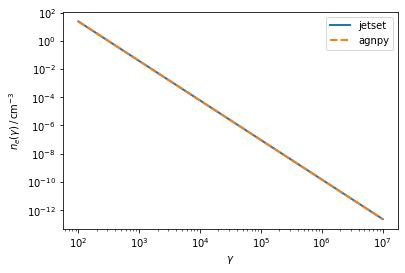

In [10]:
# check the input electron density
plt.loglog(jet.electron_distribution.gamma_e, jet.electron_distribution.n_gamma_e, lw=2, label="jetset")
plt.loglog(blob.gamma, blob.n_e(blob.gamma), lw=2, ls="--", label="agnpy")
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$n_e(\gamma)\,/\,{\rm cm}^{-3}$")
plt.legend()
plt.show()

Let us check the SEDs and their ratios

In [11]:
jet.eval()
sed_jetset = jet.SED.nuFnu

# ratio between the SEDs
sed_ratio = 1 - sed_agnpy.value / sed_jetset.value

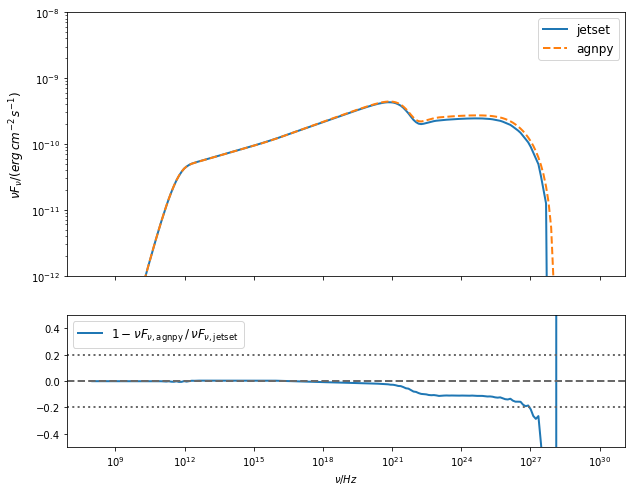

In [12]:
# plot the SEDs and the ration between the two
fig, ax = plt.subplots(2, sharex = True, gridspec_kw={"height_ratios": [2, 1]}, figsize=(10, 8))
ax[0].loglog(nu, sed_jetset, lw=2, label="jetset")
ax[0].loglog(nu, sed_agnpy, lw=2, ls="--", label="agnpy")
ax[0].legend(fontsize=12)
ax[0].set_ylim([1e-12, 1e-8])
ax[0].set_ylabel(r"$\nu F_{\nu} / (erg\,cm^{-2}\,s^{-1})$", fontsize=12)

ax[1].semilogx(nu, sed_ratio, lw=2, label=r"$1 - \nu F_{\nu, \rm agnpy} \, / \,\nu F_{\nu, \rm jetset}$")
ax[1].legend(fontsize=12, loc=2)
ax[1].set_ylim([-0.5, 0.5])
ax[1].axhline(0, ls="--", lw=2, color="dimgray")
ax[1].axhline(0.2, ls=":", lw=2, color="dimgray")
ax[1].axhline(-0.2, ls=":", lw=2, color="dimgray")
ax[1].set_xlabel(r"$\nu / Hz$")
plt.show()